In [2]:
from typing import Union
from datetime import datetime, timedelta
import warnings
import math

import numpy as np
import pandas as pd
from scipy import fft
from scipy.signal import butter, sosfilt, decimate
from scipy.ndimage import gaussian_filter
import sklearn
from sklearn.cluster import DBSCAN
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

from src import simpleDASreader, helper, dasly

In [3]:
das = dasly.Dasly()
das.load_data(
    folder_path='/media/kptruong/yellow02/Aastfjordbrua/',
    start='20230901 103015',  # full 2 lines
    # start='20231005 082445',
    # start='20230901 163100',  # part of a line
    # start='20230901 183015',  # noise
    # start='20230901 104015',  # 2 cars close to each other
    duration=60
)

Welcome to Dasly!
7 files, from 103014 to 103114


In [4]:
das.reset()
das.decimate(sampling_rate=9)
print(das.signal.shape)
das.signal

Downsampling factor: 100
New sampling rate: 10
(600, 800)


,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
10:30:15,6.978486e-06,2.660718e-06,-1.732567e-05,-1.211382e-05,5.237568e-06,1.375041e-06,-2.810786e-06,1.748303e-06,4.674918e-07,-1.137102e-06,...,-1.055907e-05,-6.551645e-06,-3.095344e-06,-5.590829e-07,2.069685e-06,5.328139e-06,2.634609e-06,-1.019593e-06,-1.374258e-06,-3.190642e-06
10:30:15.100000,-1.247592e-06,-2.179522e-07,3.210176e-06,1.825065e-06,-1.116502e-06,-2.846776e-07,5.545613e-07,-2.020630e-07,-1.221181e-07,1.649037e-07,...,1.699371e-06,1.045263e-06,5.741468e-07,2.892260e-07,-5.419669e-08,-7.254956e-07,-4.788867e-07,4.636852e-08,1.928051e-07,7.599255e-07
10:30:15.200000,3.408192e-07,-8.242761e-08,-1.119617e-06,-5.218282e-07,4.865878e-07,1.636891e-07,-2.012985e-07,4.910732e-08,5.761616e-08,-5.033213e-08,...,-5.075182e-07,-3.114751e-07,-1.872347e-07,-1.589261e-07,-1.048203e-07,1.423275e-07,1.642958e-07,4.731076e-08,-6.024978e-08,-3.516254e-07
10:30:15.300000,4.587771e-08,2.307895e-07,3.752312e-07,8.489064e-08,-2.957440e-07,-1.613829e-07,8.132075e-08,1.093004e-08,-3.753529e-08,8.109420e-09,...,1.625464e-07,8.457672e-08,9.998404e-08,1.408298e-07,1.024508e-07,-2.977516e-08,-7.449709e-08,-4.716414e-08,2.485944e-08,1.936657e-07
10:30:15.400000,-3.984118e-08,-1.324882e-07,2.911555e-07,4.516951e-07,-7.736536e-08,-6.514766e-08,3.802453e-08,-7.257704e-08,1.187620e-08,3.884406e-08,...,2.447800e-07,1.513822e-07,6.088735e-08,-3.679252e-08,-1.349249e-07,-1.709747e-07,-4.244880e-08,5.871284e-08,3.092958e-08,-2.818348e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10:31:14.500000,1.567236e-07,5.027488e-08,-5.492111e-08,1.387726e-08,-4.934428e-08,-2.500267e-08,-1.824267e-08,-1.039081e-08,8.153342e-09,1.258433e-08,...,2.046716e-08,1.353674e-08,1.304866e-08,-7.271534e-09,-1.848078e-08,8.317252e-10,1.754658e-08,1.208598e-08,-7.996663e-09,6.628368e-10
10:31:14.600000,6.958609e-08,4.502088e-08,-9.202084e-08,-9.016154e-08,1.582664e-08,3.733746e-08,-1.647468e-08,-2.636371e-08,5.962472e-09,1.824453e-08,...,1.819190e-08,8.789096e-09,1.122967e-08,1.065096e-08,3.878453e-09,-2.543642e-09,3.013088e-09,1.180039e-08,8.223067e-10,-1.473069e-08
10:31:14.700000,-3.326405e-08,7.065746e-08,1.317092e-07,-3.368113e-08,-1.043449e-07,-5.440484e-08,-2.848416e-08,-3.510043e-08,8.599905e-09,2.551588e-08,...,-1.301354e-08,-9.970591e-09,-1.658807e-09,3.398791e-09,1.083596e-08,7.618062e-09,-7.949679e-09,-5.612519e-09,-1.222565e-10,-1.817216e-08
10:31:14.800000,-3.860162e-08,1.114361e-07,2.390179e-07,4.857189e-08,-1.669286e-07,-1.522834e-07,-3.647348e-08,-2.248457e-08,8.247857e-09,1.761341e-08,...,-1.902736e-08,-1.376422e-08,-5.758368e-09,-7.119122e-09,-1.020046e-09,7.102123e-09,-5.731451e-09,-8.549987e-09,-1.506743e-09,-9.390194e-09


In [9]:
helper.cal_cov_mat(90, 95, 90)

array([[8106.15401707,  315.38068873],
       [ 315.38068873,   20.81601437]])

In [6]:
data = das.signal

time_gap = None
times = data.index  # values of y-axis
times = [i.isoformat(timespec='seconds') for i in times]
divisors = helper.find_divisors(len(times))
nlabels = helper.largest_smaller_than_threshold(divisors, 20)
if time_gap is None:
    time_gap = dasly.Dasly.find_duration(data) / nlabels
sample_gap = time_gap * len(times) / dasly.Dasly.find_duration(data)
sample_gap = int(sample_gap)
time_positions = np.arange(0, len(times), sample_gap)
time_labels = times[::sample_gap]
# plt.yticks(time_positions, time_labels)

In [17]:
nlabels

20

In [20]:
dasly.Dasly.find_duration(data)

0.1

In [27]:
time0 = data.index[0]
time1 = data.index[1]
# Convert the time to datetime.datetime objects with a common date
common_date = datetime.today().date()
datetime0 = datetime.combine(common_date, time0)
datetime1 = datetime.combine(common_date, time1)
# Calculate the time difference
time_difference = datetime1 - datetime0
# Get the time difference in seconds
duration = time_difference.total_seconds() * len(data)

duration

6.0

In [25]:
time0

datetime.time(10, 30, 15)

In [26]:
time1

datetime.time(10, 30, 15, 100000)

In [17]:
time_gap * das.sampling_rate % 1

0.40000000000000036

In [9]:
nlabels

20

In [11]:
das.duration / nlabels

0.3

In [8]:
divisors

[1, 2, 3, 6]

In [37]:
nlabels

6

In [19]:
das.duration // 

SyntaxError: invalid syntax (2677797994.py, line 1)

In [19]:
def plot(cov_mat, mean=[0, 0]) -> None:
    plt.figure(figsize=(4, 4))
    degree = 45
    radian = degree / 180 * np.pi
    tan = np.tan(radian)
    plt.axline((0, 0), (1, tan), color='gray')

    degree = 30
    radian = degree / 180 * np.pi
    tan = np.tan(radian)
    plt.axline((0, 0), (1, tan), color='gray')

    degree = 60
    radian = degree / 180 * np.pi
    tan = np.tan(radian)
    plt.axline((0, 0), (1, tan), color='gray')

    data = np.random.multivariate_normal(mean, cov_mat, 1000)
    data = pd.DataFrame(data, columns=['Space', 'Time'])
    sns.kdeplot(data=data, x='Space', y='Time', fill=True)
    lim = np.max(data)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

In [30]:
cov = helper.cal_cov_mat(90, 95, 5)
cov

array([[25.01899388,  0.97339719],
       [ 0.97339719,  0.06424696]])

In [52]:
type(cov)

list

In [92]:
cov = [[1000, 0], [0, 10]]

In [93]:
gauss = helper.create_gauss_filter(cov, sampling_rate=1)
print(gauss.shape)

(14, 127)


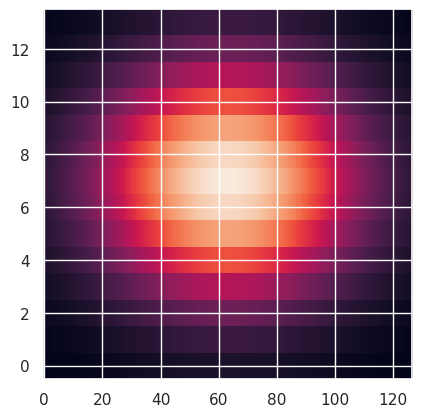

In [94]:
plt.imshow(
    X=gauss,
    aspect=gauss.shape[1] / gauss.shape[0],  # square
    # cmap=cmap,
    # norm=norm,
    interpolation='none',  # no interpolation
    # to see the last values of x-axis
    # extent=[0, self.signal.shape[1], 0, self.signal.shape[0]],
    origin='lower'
)

In [16]:
das.sampling_rate

10.0

In [22]:
sample_gap

24

In [21]:
time_gap

3

In [4]:
def find_divisors(number: int) -> list[int]:
    """List all divisors of an integer number.

    Args:
        number (int): Input number.

    Returns:
        list[int]: List of divisors of input number.
    """
    divisors = []
    for i in range(1, number + 1):
        if number % i == 0:
            divisors.append(i)
    return divisors

In [48]:
duration = 200
# adjust the y-axis to time
y = das.signal.index  # values of y-axis

start_time = datetime.combine(datetime.today(), y[0])
end_time = datetime.combine(datetime.today(), y[-1])

divisors = helper.find_divisors(duration)
nlabels = helper.largest_smaller_than_threshold(divisors, 20)
time_gap = duration // nlabels
time_gap = timedelta(seconds=time_gap)
time_list = [start_time + i * time_gap for i in range(nlabels)]
time_list = [i.time() for i in time_list]
print(len(time_list))
time_list

indices = [y.index(value) for value in time_list]


# y = [i.isoformat(timespec='seconds') for i in y]
# ny = len(y)
# no_labels = 15  # how many labels to see on axis y
# step_y = int(ny / (no_labels - 1))  # step between consecutive labels
# y_positions = np.arange(0, ny, step_y)  # pixel count at label position
# y_labels = y[::step_y]  # labels you want
# plt.yticks(y_positions, y_labels)

20


[datetime.time(10, 30, 15),
 datetime.time(10, 30, 25),
 datetime.time(10, 30, 35),
 datetime.time(10, 30, 45),
 datetime.time(10, 30, 55),
 datetime.time(10, 31, 5),
 datetime.time(10, 31, 15),
 datetime.time(10, 31, 25),
 datetime.time(10, 31, 35),
 datetime.time(10, 31, 45),
 datetime.time(10, 31, 55),
 datetime.time(10, 32, 5),
 datetime.time(10, 32, 15),
 datetime.time(10, 32, 25),
 datetime.time(10, 32, 35),
 datetime.time(10, 32, 45),
 datetime.time(10, 32, 55),
 datetime.time(10, 33, 5),
 datetime.time(10, 33, 15),
 datetime.time(10, 33, 25)]

In [49]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9]
b = [3, 6, 9]

indices = [index for index, value in enumerate(a) if value in b]

print(indices)

[2, 5, 8]


In [42]:
divisors = helper.find_divisors(32)
divisors

[1, 2, 4, 8, 16, 32]

In [30]:
time_list

[datetime.time(10, 30, 15),
 datetime.time(10, 30, 30),
 datetime.time(10, 30, 45),
 datetime.time(10, 31),
 datetime.time(10, 31, 15),
 datetime.time(10, 31, 30),
 datetime.time(10, 31, 45),
 datetime.time(10, 32),
 datetime.time(10, 32, 15),
 datetime.time(10, 32, 30),
 datetime.time(10, 32, 45),
 datetime.time(10, 33)]

11

In [21]:
88/11

8.0

In [50]:
from datetime import time, timedelta

# Initial time object
start_time = time(10, 30, 45)
start_time = datetime.combine(datetime.today(), start_time)

# Gap between each time
time_gap = timedelta(seconds=30)

# Generate a list of 12 time values with a 30-second gap
time_list = [start_time + i * time_gap for i in range(12)]
time_list = [i.time() for i in time_list]

print(time_list)


[datetime.time(10, 30, 45), datetime.time(10, 31, 15), datetime.time(10, 31, 45), datetime.time(10, 32, 15), datetime.time(10, 32, 45), datetime.time(10, 33, 15), datetime.time(10, 33, 45), datetime.time(10, 34, 15), datetime.time(10, 34, 45), datetime.time(10, 35, 15), datetime.time(10, 35, 45), datetime.time(10, 36, 15)]


In [19]:
find_divisors(625)

[1, 5, 25, 125, 625]

In [20]:
625/5

125.0

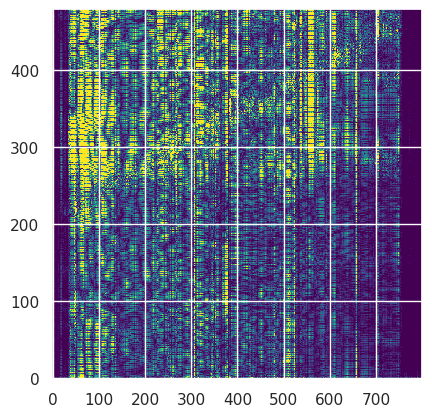

In [ ]:
percentile = np.quantile(np.abs(das.signal), 0.95)
vmin = 0
vmax = percentile

norm = colors.TwoSlopeNorm(
    vmin=vmin,
    vmax=vmax,
    vcenter=(vmin + vmax) / 2
)
cmap = 'viridis'

plt.imshow(
    X=das.signal.values,
    aspect=das.signal.shape[1] / das.signal.shape[0],  # square
    cmap=cmap,
    norm=norm,
    interpolation='none',  # no interpolation
    origin='lower'
);

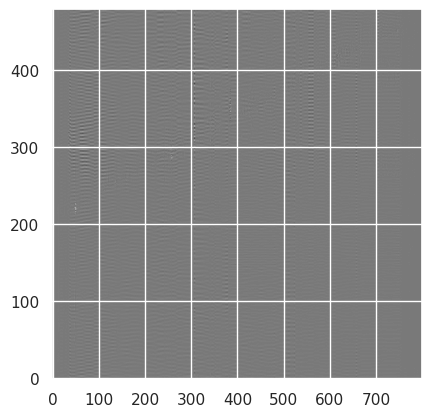

In [ ]:
plt.imshow(
    das.signal,
    cmap='gray',
    origin='lower',
    aspect=das.signal.shape[1] / das.signal.shape[0]
);

Threshold 1


,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
10:30:15,1,1,1,1,1,0,1,0,0,0,...,1,1,1,0,0,1,1,0,0,1
10:30:15.125000,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:15.250000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:15.375000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:15.500000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10:30:24.375000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:24.500000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:24.625000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:24.750000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
factor_adjusted = 1.87

In [ ]:
np.uint8

numpy.uint8

In [ ]:
print(f'Downsampling factor: {factor_adjusted:.10g}')

Downsampling factor: 1.87


In [ ]:
(np.abs(das.signal) >= 7.052111e-06).astype(int)

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
10:30:15,1,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10:30:15.125000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:15.250000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:15.375000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:15.500000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10:30:24.375000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:24.500000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:24.625000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:30:24.750000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
das.decimate(min_sampling_rate=13, inplace=True)

TypeError: decimate() got an unexpected keyword argument 'min_sampling_rate'

In [ ]:
factor = 4.0


Downsampling with factor 4


In [ ]:
das.sampling_rate

20.0

In [ ]:
(1+3)

In [ ]:
(np.abs(das.signal) >= 6.497454e-06).astype(int)

In [ ]:
if 0 <= 0.5 <= 0:
    print(True)

In [ ]:
def find_divisors(number) -> list[int]:
    divisors = []
    for i in range(1, number + 1):
        if number % i == 0:
            divisors.append(i)
    return divisors

In [ ]:
find_divisors(5.0)